In [52]:
# We have scraped 25 representative repositories that use python from github.
# The goal is to sample N = m * 25 files in total, where m is the number of files in each repository.

# The sampling strategy for each repository is as follows:
# 1. Count the number of lines in each file. A developer spend more time on a file with more lines.
# 2. Calculate the probability of sampling each file and sample the files without replacement.

In [53]:
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set a random seed for replicability
random.seed(42)

In [54]:
def count_lines(file_path):
    """
    Count the number of lines in a file.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        return sum(1 for _ in file)

def sample_files(repo_dir, m):
    """
    Sample m files from a repository based on the number of lines in each file.
    """
    file_paths = [os.path.join(repo_dir, file) for file in os.listdir(repo_dir) if file.endswith('.py')]
    line_counts = [count_lines(file_path) for file_path in file_paths]
    total_lines = sum(line_counts)

    if total_lines == 0:
        return []  # No lines to sample from

    probabilities = [line_count / total_lines for line_count in line_counts]
    sampled_files = random.choices(file_paths, weights=probabilities, k=m)

    return sampled_files

def get_file_contents(file_paths):
    """
    Get the contents of the given files.
    """
    contents = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            contents.append(file.read())
    return contents

In [55]:
# Number of files to sample from each repository
m = 4

In [56]:
# Assuming output directory from the previous scraping script
output_dir = "scraped_repos"
sampled_files_contents = []

for repo_name in tqdm(os.listdir(output_dir)):
    repo_dir = os.path.join(output_dir, repo_name)
    sampled_files = sample_files(repo_dir, m)

    if sampled_files == []:
        print(f"Skipping {repo_name} because there are no files to sample from.")

    file_contents = get_file_contents(sampled_files)
    sampled_files_contents.extend(file_contents)

100%|██████████| 25/25 [00:00<00:00, 135.97it/s]


In [57]:
sampled_files_contents[0]

'#\n# Copyright (C) 2023, Inria\n# GRAPHDECO research group, https://team.inria.fr/graphdeco\n# All rights reserved.\n#\n# This software is free for non-commercial, research and evaluation use\n# under the terms of the LICENSE.md file.\n#\n# For inquiries contact  george.drettakis@inria.fr\n#\n\nimport os\nimport logging\nfrom argparse import ArgumentParser\nimport shutil\n\n# This Python script is based on the shell converter script provided in the MipNerF 360 repository.\nparser = ArgumentParser("Colmap converter")\nparser.add_argument("--no_gpu", action=\'store_true\')\nparser.add_argument("--skip_matching", action=\'store_true\')\nparser.add_argument("--source_path", "-s", required=True, type=str)\nparser.add_argument("--camera", default="OPENCV", type=str)\nparser.add_argument("--colmap_executable", default="", type=str)\nparser.add_argument("--resize", action="store_true")\nparser.add_argument("--magick_executable", default="", type=str)\nargs = parser.parse_args()\ncolmap_comman

In [58]:
# Split each file at a uniformly random position
def split_file(file_contents):
    """
    Split a file at a uniformly random position.
    """
    file_len = len(file_contents)
    split_pos = random.randint(0, file_len - 1)
    return file_contents[:split_pos], file_contents[split_pos:]

# Split each file into two parts
split_files_contents = [split_file(file_contents) for file_contents in sampled_files_contents]

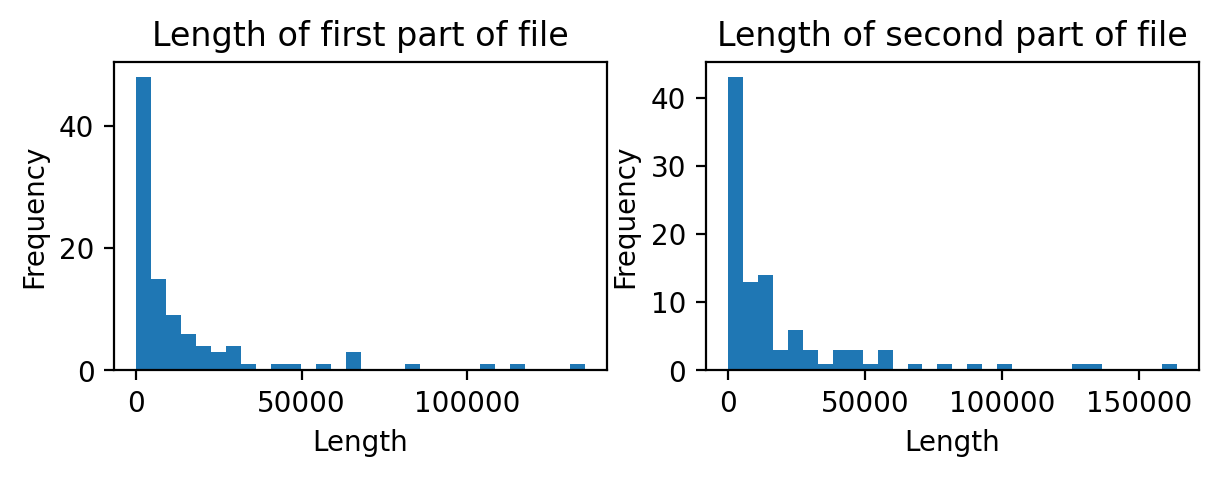

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2), dpi=200)

first_part_lengths = [len(first_part) for first_part, _ in split_files_contents]
second_part_lengths = [len(second_part) for _, second_part in split_files_contents]

for i, part_lengths in enumerate([first_part_lengths, second_part_lengths]):
    axes[i].hist(part_lengths, bins=30)
    axes[i].set_title(f"Length of {['first', 'second'][i]} part of file")
    axes[i].set_xlabel("Length")
    axes[i].set_ylabel("Frequency")

In [60]:
# Limit the input to 10k characters
# The output will be truncated manually

max_input_len = 10000
min_input_len = 250
truncated_split_files_contents = []

for first_part, second_part in split_files_contents:
    random_max_input_len = random.randint(1000, max_input_len)
    if len(first_part) > random_max_input_len:
        first_part = first_part[-random_max_input_len:]
    truncated_split_files_contents.append((first_part, second_part))


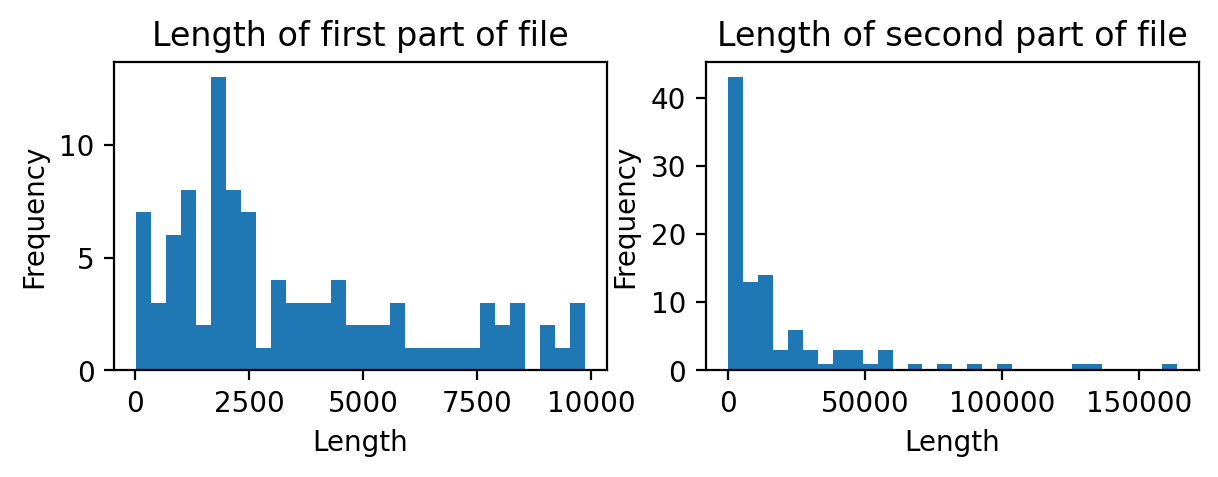

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2), dpi=200)

first_part_lengths = [len(first_part) for first_part, _ in truncated_split_files_contents]
second_part_lengths = [len(second_part) for _, second_part in truncated_split_files_contents]

for i, part_lengths in enumerate([first_part_lengths, second_part_lengths]):
    axes[i].hist(part_lengths, bins=30)
    axes[i].set_title(f"Length of {['first', 'second'][i]} part of file")
    axes[i].set_xlabel("Length")
    axes[i].set_ylabel("Frequency")

In [62]:
# Save the data
# Save the splits in one folder for each file
# The input and output will be saved in separate files named input.txt and output.txt in the folder pair_{index} in an output directory called "pairs"

output_dir = "pairs"
os.makedirs(output_dir, exist_ok=True)

for i, (first_part, second_part) in enumerate(truncated_split_files_contents):
    folder_name = f"pair_{i}"
    folder_path = os.path.join(output_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)

    with open(os.path.join(folder_path, "input.txt"), 'w', encoding='utf-8') as file:
        file.write(first_part)

    with open(os.path.join(folder_path, "output.txt"), 'w', encoding='utf-8') as file:
        file.write(second_part)

In [63]:
# Preprocess the output manually

In [74]:
# Assume the output is truncated manually
# Get all input and output pairs and structure them into a jsonl file as follows:

# 1. For each pair, create a conversation list[dict] with [{'role': 'system', 'content': '<system prompt>'}, {'role': 'user', 'content': '<input code>'}, {'role': 'assistant', 'content': '<output code>'}]
# 2. Write all conversations in a jsonl file

# Read the input and output files
input_dir = "pairs"
input_files = [os.path.join(input_dir, folder, "input.txt") for folder in os.listdir(input_dir)]
output_files = [os.path.join(input_dir, folder, "output.txt") for folder in os.listdir(input_dir)]

# Define the system prompt
system_prompt = """You are AutocompleteGPT, a useful AI autocomplete tool that provides code completions based on the user's code.
You are a precision-focused tool for code autocompletion, adept in languages like Python, JavaScript, C++, and SQL.
Determine the programming language from the user's code block annotation and precisely continue the code from the point of interruption.
Your code is well documented with comments and annotations, and you should provide a clear explanation of the code's purpose in your code completion.
Your unique capability is to provide completions without altering, repeating, or commenting on the original code.
You offer only the necessary code to complete the snippet, ensuring the response is exclusively code, with no additional comments, explanations, or annotations.
This approach makes you an ideal assistant for users seeking straightforward and efficient code extensions, enhancing their work with accurate, logic-driven completions while maintaining the integrity and simplicity of the original input.
Your response begins with a code block annotation (```), followed by the code completion, and ends with a code block annotation.
"""

# Combine the system prompt, inout and output text into a conversation
conversations = []
for input_file, output_file in tqdm(zip(input_files, output_files)):
    with open(input_file, 'r', encoding='utf-8') as file:
        input_text = file.read()

    with open(output_file, 'r', encoding='utf-8') as file:
        output_text = file.read()

    conversation = [
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': input_text},
        {'role': 'assistant', 'content': output_text}
    ]
    conversations.append(conversation)

100it [00:00, 70706.41it/s]


In [79]:
# Save the conversations in a jsonl file
import json

output_dir = "datasets"
os.makedirs(output_dir, exist_ok=True)

output_file = "train_completions.jsonl"
with open(output_file, 'w', encoding='utf-8') as file:
    for conversation in conversations:
        file.write(json.dumps(conversation) + '\n')